LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [1]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [2]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [3]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [4]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [5]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [6]:
# |x| <= t
def absval(M, x, t):
    M.constraint(Expr.add(t, x), Domain.greaterThan(0.0))
    M.constraint(Expr.sub(t, x), Domain.greaterThan(0.0))

# ||x||_1 <= t
def norm1(M, x, t):
    u = M.variable(x.getShape(), Domain.unbounded())
    absval(M, x, u)
    M.constraint(Expr.sub(Expr.sum(u), t), Domain.equalsTo(0.0))

def EfficientFrontier(N, m, G, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings relative to the initial capital. 
        # It is a free variable, allowing long and short positions.   
        x = M.variable("x", N, Domain.unbounded())
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
        
        # Gross exposure constraint (allows 2 times the initial capital)
        norm1(M, x, 2.0)
        
        # Dollar neutrality constraint
        M.constraint('neutrality', Expr.sum(x), Domain.equalsTo(0.0))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(m, x), Expr.mul(delta, s)))

        # Conic constraint for the portfolio variance 
        M.constraint('risk', Expr.vstack(s, 0.5, Expr.mul(G.transpose(), x)), Domain.inRotatedQCone())
        
        # Create DataFrame to store the results. Last security name (the SPY) is removed.
        columns = ["delta", "obj", "return", "risk"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = np.sqrt(s.level()[0])
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk] + list(x.level()), index=columns)
            df_result = df_result.append(row, ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [7]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m, S = compute_inputs(df_prices)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [8]:
G = np.linalg.cholesky(S)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{1.5}$. We compute the efficient frontier this way both with and without using shrinkage estimation. 

In [9]:
# Compute efficient frontier with and without shrinkage
deltas = np.logspace(start=-1, stop=1.5, num=20)[::-1]
df_result = EfficientFrontier(N, m, G, deltas)

Check the results.

In [10]:
df_result

,delta,obj,return,risk,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,31.622777,0.012181,0.024362,0.019627,-0.029866,-1.813651e-03,-3.327063e-03,-3.965543e-02,0.017223,4.664747e-02,2.347876e-02,-1.268697e-02
1,23.357215,0.016492,0.032983,0.026572,-0.040435,-2.455977e-03,-4.504609e-03,-5.368734e-02,0.023318,6.315380e-02,3.178662e-02,-1.717610e-02
2,17.252105,0.022328,0.044655,0.035975,-0.054743,-3.324976e-03,-6.098627e-03,-7.268608e-02,0.031570,8.550237e-02,4.303523e-02,-2.325436e-02
3,12.742750,0.030229,0.060457,0.048705,-0.074115,-4.501704e-03,-8.256829e-03,-9.840758e-02,0.042741,1.157593e-01,5.826417e-02,-3.148341e-02
4,9.412050,0.040926,0.081850,0.065940,-0.100340,-6.094617e-03,-1.117865e-02,-1.332288e-01,0.057866,1.567183e-01,7.888206e-02,-4.262430e-02
5,6.951928,0.055409,0.110821,0.089279,-0.135856,-8.250688e-03,-1.513487e-02,-1.803870e-01,0.078346,2.121911e-01,1.068038e-01,-5.771226e-02
6,5.134833,0.075016,0.150038,0.120873,-0.183931,-1.117063e-02,-2.049049e-02,-2.442261e-01,0.106069,2.872826e-01,1.446022e-01,-7.813558e-02
7,3.792690,0.101563,0.203125,0.163641,-0.249013,-1.512627e-02,-2.774053e-02,-3.306328e-01,0.143605,3.889271e-01,1.957575e-01,-1.057763e-01
8,2.801357,0.137504,0.275011,0.221554,-0.337138,-2.047841e-02,-3.756367e-02,-4.476385e-01,0.194424,5.265729e-01,2.650385e-01,-1.432172e-01
9,2.069138,0.177107,0.298429,0.242145,-0.415083,-1.588445e-07,-3.462877e-08,-5.158595e-01,0.246408,5.503360e-01,2.032559e-01,-6.905687e-02


## Visualize the results

Plot the efficient frontier.

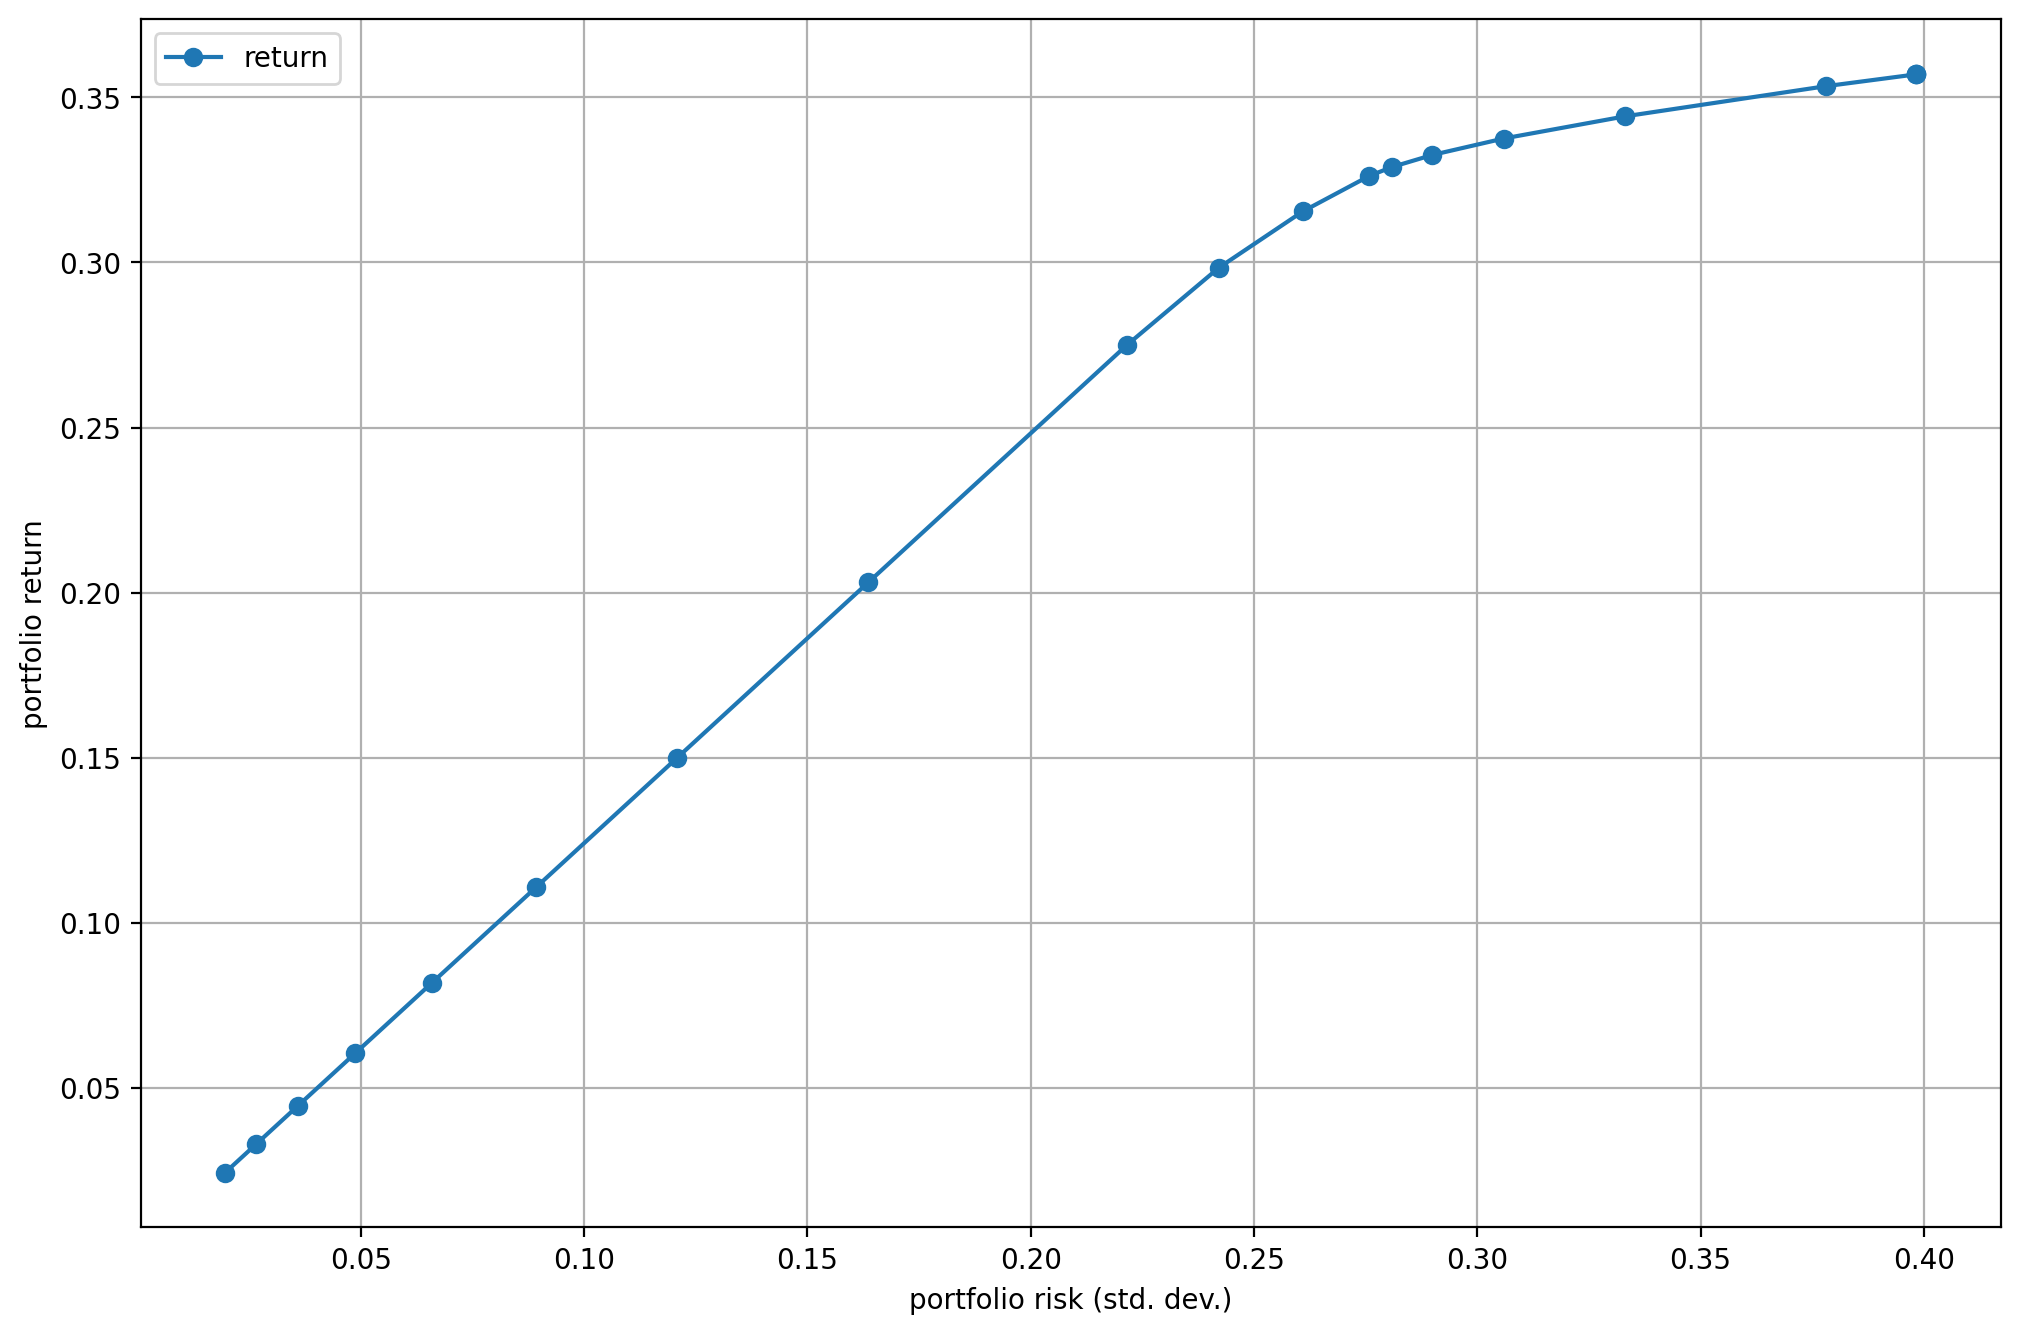

In [11]:
ax = df_result.plot(x="risk", y="return", style="-o", 
                    xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)   
ax.legend(["return"]);

Plot the portfolio composition.

In [12]:
# Round small values to 0 to make plotting work
mask = np.absolute(df_result) < 1e-7
mask.iloc[:, :-8] = False
df_result[mask] = 0

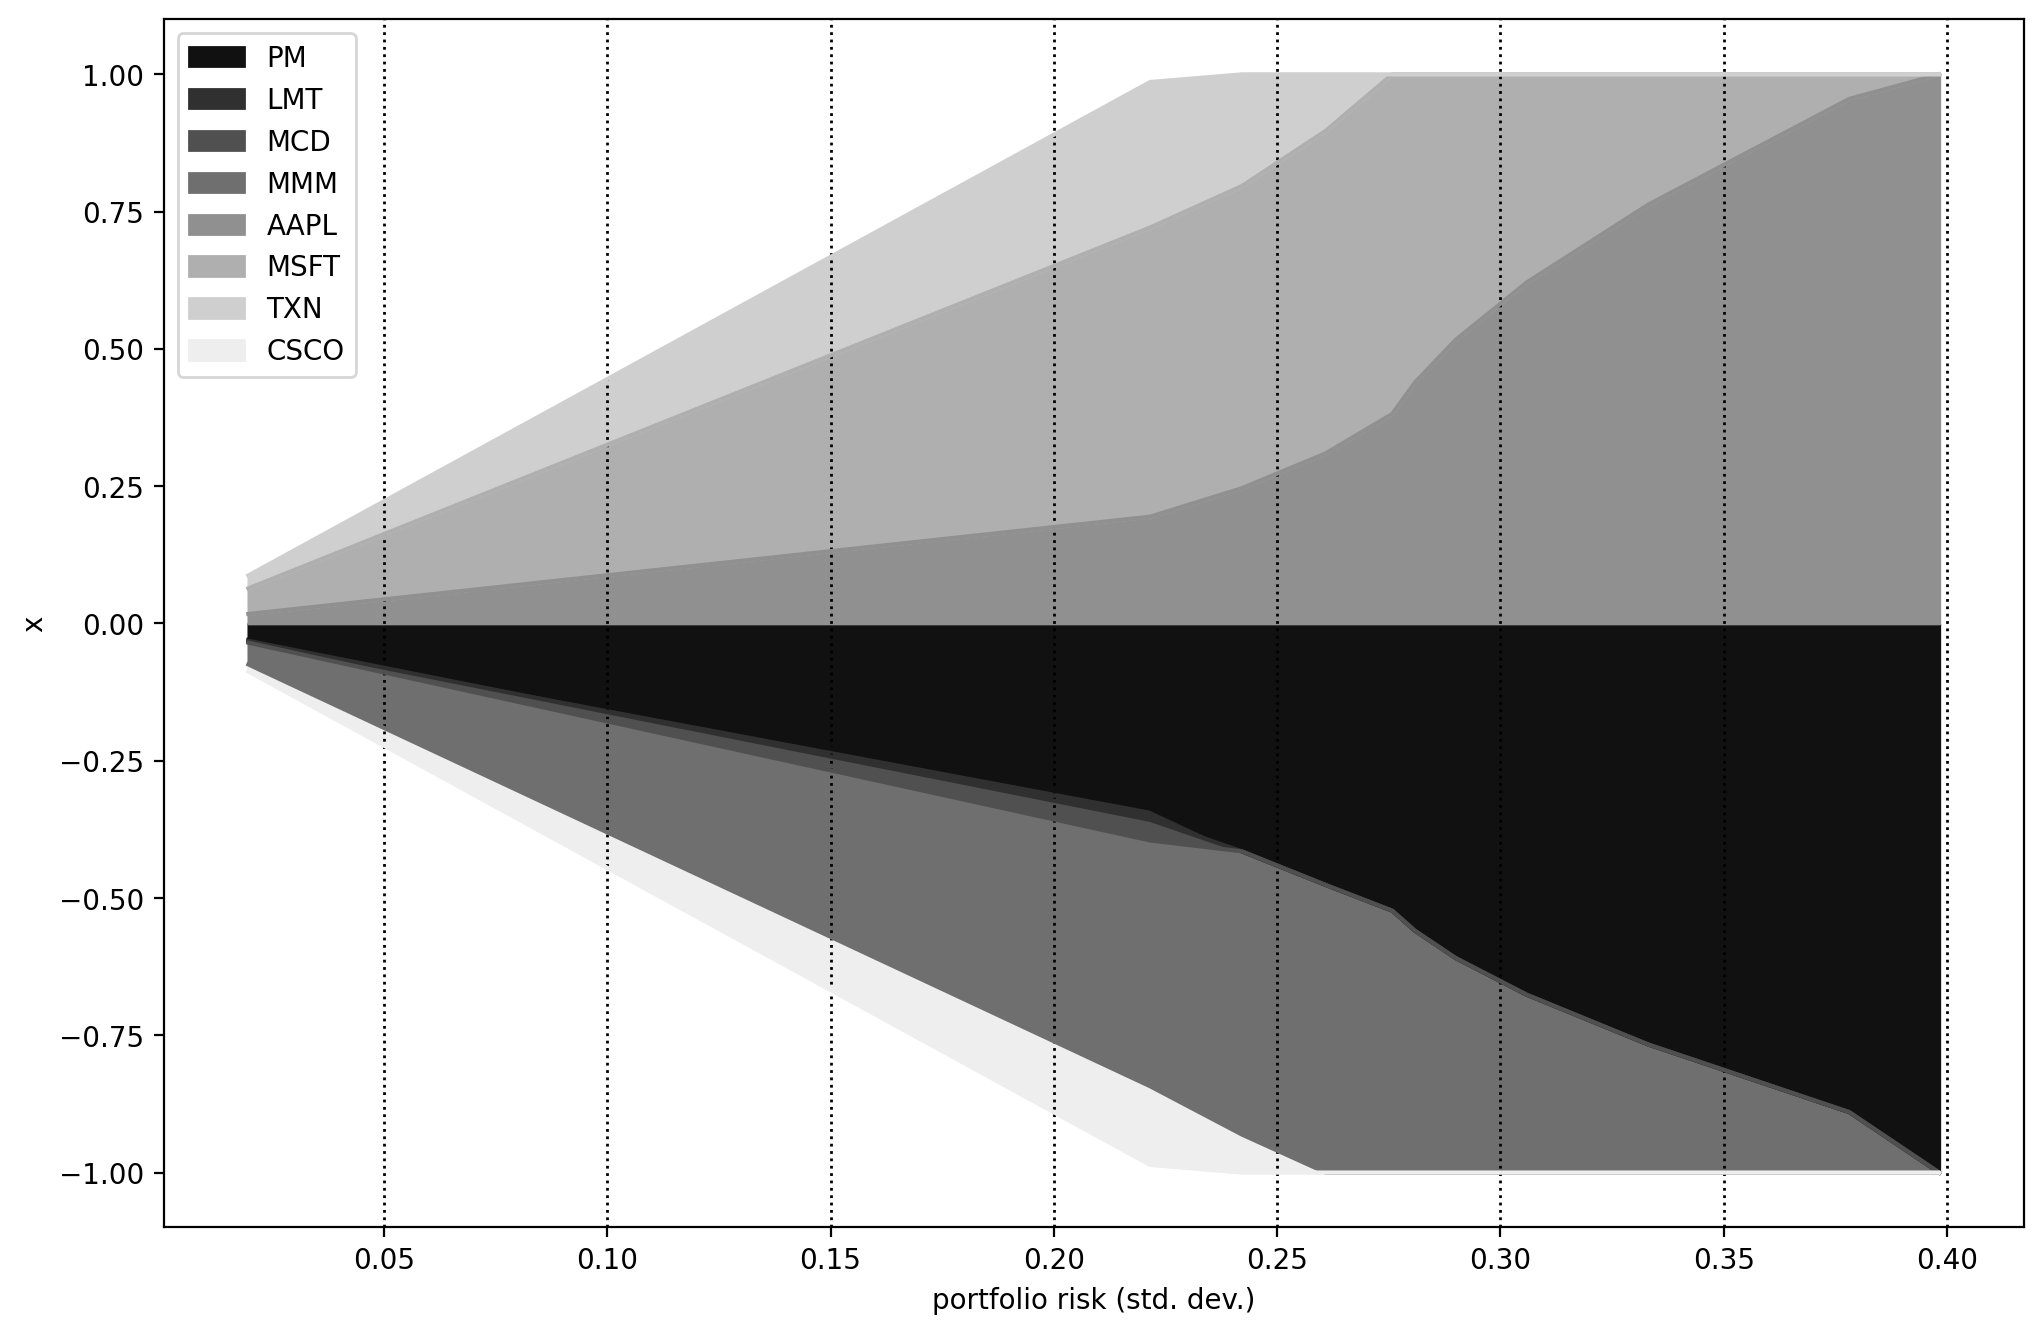

In [13]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = df_result.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x") 
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)